### Explore `processed_geom_val.pt`

Path: `/home/aidens/metagen/tabasco/src/data/processed_geom_val.pt`

This notebook loads the validation split and gives a quick structural overview and basic visualizations to understand the data format.


In [1]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = Path("/home/aidens/metagen/tabasco/src/data/processed_geom_val.pt")
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH}"

print("Torch:", torch.__version__)
print("File:", DATA_PATH)
print("Size (MB):", round(DATA_PATH.stat().st_size / 1e6, 2))


Torch: 2.8.0+cu128
File: /home/aidens/metagen/tabasco/src/data/processed_geom_val.pt
Size (MB): 217.47


In [2]:
# Load with PyTorch 2.6+ safety handling and RDKit allowlist
from torch.serialization import add_safe_globals

device = "cuda" if torch.cuda.is_available() else "cpu"
obj = None
try:
    # Allowlist RDKit Mol for safe unpickling when weights_only=True
    from rdkit.Chem.rdchem import Mol  # type: ignore
    add_safe_globals([Mol])
    obj = torch.load(DATA_PATH, map_location=device, weights_only=True)
except Exception as e1:
    print("Safe load failed, falling back to weights_only=False. Reason:", e1)
    obj = torch.load(DATA_PATH, map_location=device, weights_only=False)

print(type(obj))

# Try to be agnostic to format (dict/list/tuple/custom)
if isinstance(obj, dict):
    print("Dict keys:", list(obj.keys())[:20])
    sample = obj
elif isinstance(obj, (list, tuple)):
    print("Sequence length:", len(obj))
    sample = obj[0] if len(obj) > 0 else None
else:
    sample = obj

print("Sample type:", type(sample))

# If PyTorch Geometric or custom dataclass-like
for attr in [
    'z', 'pos', 'charges', 'num_nodes', 'num_graphs',
    'edge_index', 'edge_attr', 'mask', 'batch'
]:
    if hasattr(sample, attr):
        val = getattr(sample, attr)
        try:
            shape = tuple(val.shape)
        except Exception:
            shape = None
        print(f"attr {attr}: type={type(val)}, shape={shape}")

# If it's a dict/sample try common keys
common_keys = ['z', 'pos', 'coords', 'atomic_numbers', 'num_atoms', 'edges']
if isinstance(sample, dict):
    for k in common_keys:
        if k in sample:
            v = sample[k]
            try:
                shape = tuple(v.shape)
            except Exception:
                shape = None
            print(f"key {k}: type={type(v)}, shape={shape}")


<class 'list'>
Sequence length: 146411
Sample type: <class 'tuple'>


In [3]:
# Resolve sample when the loaded object is a tuple with many None
from typing import Any

def is_graph_like(x: Any) -> bool:
    try:
        if isinstance(x, dict):
            return ('z' in x or 'atomic_numbers' in x) and ('pos' in x or 'coords' in x)
        return hasattr(x, 'z') and hasattr(x, 'pos')
    except Exception:
        return False


def find_first_graph(x: Any, depth: int = 0, max_depth: int = 3):
    if depth > max_depth:
        return None
    if x is None:
        return None
    if is_graph_like(x):
        return x
    if isinstance(x, (list, tuple)):
        for el in x:
            g = find_first_graph(el, depth + 1, max_depth)
            if g is not None:
                return g
    if isinstance(x, dict):
        for v in x.values():
            g = find_first_graph(v, depth + 1, max_depth)
            if g is not None:
                return g
    return None

# Quick summary for tuples/lists
if isinstance(obj, (list, tuple)):
    types = [(i, type(el).__name__) for i, el in enumerate(obj)]
    none_count = sum(el is None for el in obj)
    print(f"Top-level container length: {len(obj)}; None entries: {none_count}")
    print("First 10 element types:", types[:10])

new_sample = find_first_graph(obj)
if new_sample is not None:
    sample = new_sample
    print("Resolved a graph-like sample:", type(sample))
else:
    print("Could not resolve a graph-like sample; keeping previous sample.")

# Try to find a container of graphs for stats
graphs_for_stats = None
if isinstance(obj, (list, tuple)):
    lvl0 = [el for el in obj if is_graph_like(el)]
    if lvl0:
        graphs_for_stats = lvl0
    else:
        nested = []
        for el in obj:
            if isinstance(el, (list, tuple)):
                nested.extend([x for x in el if is_graph_like(x)])
        if nested:
            graphs_for_stats = nested

if graphs_for_stats is not None:
    print(f"Graphs container resolved with {len(graphs_for_stats)} items")
else:
    print("No graphs container resolved at top two nesting levels")


Top-level container length: 146411; None entries: 0
First 10 element types: [(0, 'tuple'), (1, 'tuple'), (2, 'tuple'), (3, 'tuple'), (4, 'tuple'), (5, 'tuple'), (6, 'tuple'), (7, 'tuple'), (8, 'tuple'), (9, 'tuple')]
Could not resolve a graph-like sample; keeping previous sample.
No graphs container resolved at top two nesting levels


In [4]:
# Build a getter to extract atom types and coordinates from various formats
from typing import Tuple, Optional

def to_numpy(x):
    import numpy as _np
    import torch as _torch
    if x is None:
        return None
    if isinstance(x, _torch.Tensor):
        return x.detach().cpu().numpy()
    try:
        arr = _np.asarray(x)
        # Normalize degenerate object array wrapping None
        if arr.dtype == object and arr.shape == ():
            try:
                if arr.item() is None:
                    return None
            except Exception:
                pass
        return arr
    except Exception:
        return None


def get_atoms_and_coords(obj) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    # Dict-like
    if isinstance(obj, dict):
        z = obj.get('z') or obj.get('atomic_numbers')
        pos = obj.get('pos') or obj.get('coords')
        return to_numpy(z), to_numpy(pos)

    # Tuple/list heuristic: find 1D int-like z and (N,3) float-like pos
    if isinstance(obj, (list, tuple)):
        z_cand = None
        pos_cand = None
        for el in obj:
            arr = to_numpy(el)
            if arr is None:
                continue
            if arr.ndim == 1 and arr.size > 0 and (str(arr.dtype).startswith('int') or arr.dtype == np.int64 or arr.dtype == np.int32):
                # Heuristic for atomic numbers range
                if np.nanmin(arr) >= 0 and np.nanmax(arr) <= 118:
                    if z_cand is None:
                        z_cand = arr
            if arr.ndim == 2 and arr.shape[1] == 3 and np.issubdtype(arr.dtype, np.number):
                if pos_cand is None:
                    pos_cand = arr
        return z_cand, pos_cand

    # PyG Data-like: attributes
    for a in ['z', 'atomic_numbers']:
        if hasattr(obj, a):
            z = getattr(obj, a)
            break
    else:
        z = None
    for a in ['pos', 'coords']:
        if hasattr(obj, a):
            pos = getattr(obj, a)
            break
    else:
        pos = None
    return to_numpy(z), to_numpy(pos)

z_np, pos_np = get_atoms_and_coords(sample)
print("z shape:", None if z_np is None else z_np.shape)
print("pos shape:", None if pos_np is None else pos_np.shape)

if z_np is not None and pos_np is not None:
    # Cast to int for readability if needed
    try:
        uniq = np.unique(z_np.astype(int))
    except Exception:
        uniq = np.unique(z_np)
    print("Unique atomic numbers:", uniq)
    print("# atoms:", len(z_np))


z shape: None
pos shape: None


In [5]:
# Compute statistics across the entire dataset
from tqdm import tqdm

num_atoms_list = []
atom_types_counter = {}
smiles_list = []

# Sample a subset for faster analysis (or use all if you want)
sample_size = min(1000, len(obj))
print(f"Analyzing {sample_size} molecules...")

for i in tqdm(range(sample_size)):
    _, mol = obj[i]
    if mol is None:
        continue
        
    # Count atoms
    num_atoms = mol.GetNumAtoms()
    num_atoms_list.append(num_atoms)
    
    # Count atom types
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        atom_types_counter[symbol] = atom_types_counter.get(symbol, 0) + 1
    
    # Get SMILES
    try:
        smiles = Chem.MolToSmiles(mol)
        smiles_list.append(smiles)
    except:
        pass

# Print statistics
num_atoms_array = np.array(num_atoms_list)
print(f"\n=== Dataset Statistics ===")
print(f"Total molecules analyzed: {len(num_atoms_list)}")
print(f"Atoms per molecule:")
print(f"  Mean: {num_atoms_array.mean():.2f}")
print(f"  Median: {np.median(num_atoms_array):.0f}")
print(f"  Min: {num_atoms_array.min()}")
print(f"  Max: {num_atoms_array.max()}")
print(f"\nAtom type distribution:")
sorted_atoms = sorted(atom_types_counter.items(), key=lambda x: x[1], reverse=True)
for atom, count in sorted_atoms[:10]:
    print(f"  {atom}: {count}")
print(f"\nUnique SMILES: {len(set(smiles_list))}/{len(smiles_list)}")

Analyzing 1000 molecules...


100%|██████████| 1000/1000 [00:00<00:00, 11943.49it/s]


=== Dataset Statistics ===
Total molecules analyzed: 1000
Atoms per molecule:
  Mean: 49.26
  Median: 40
  Min: 17
  Max: 156

Atom type distribution:
  H: 22629
  C: 19559
  N: 4062
  O: 2354
  S: 322
  Br: 168
  Cl: 100
  F: 70

Unique SMILES: 0/0


In [15]:
smiles_list

[]

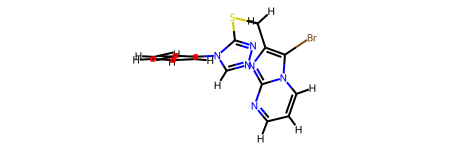

In [10]:
_, mol = obj[1]
mol

In [14]:
Chem.MolToSmiles(mol)

'[H]c1nc2nc(C([H])([H])Sc3nnc([H])n3-c3c([H])c([H])c([H])c([H])c3[H])c(Br)n2c([H])c1[H]'

In [17]:
from rdkit.Chem import AllChem, Draw

AllChem.Compute2DCoords(mol)                 # for drawing
cid = AllChem.EmbedMolecule(mol)             # 3D conformer
confs = mol.GetConformers()                  # manage multiple conformers
AllChem.MMFFOptimizeMoleculeConfs(mol)

[(0, 81.07551497575041)]

In [21]:
def mol_to_arrays(mol):
    """
    Extract atomic numbers and 3D coordinates from an RDKit molecule.
    
    Args:
        mol: RDKit Mol object with conformer
    
    Returns:
        z_np: numpy array of atomic numbers (shape: [n_atoms])
        pos_np: numpy array of 3D coordinates (shape: [n_atoms, 3])
    """
    import numpy as np
    from rdkit import Chem

    # Get atomic numbers
    z_np = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])

    # Get 3D coordinates from the first conformer
    conformer = mol.GetConformer(0)  # Get first (or only) conformer
    pos_np = np.array([conformer.GetAtomPosition(i) for i in range(mol.GetNumAtoms())])

    return z_np, pos_np

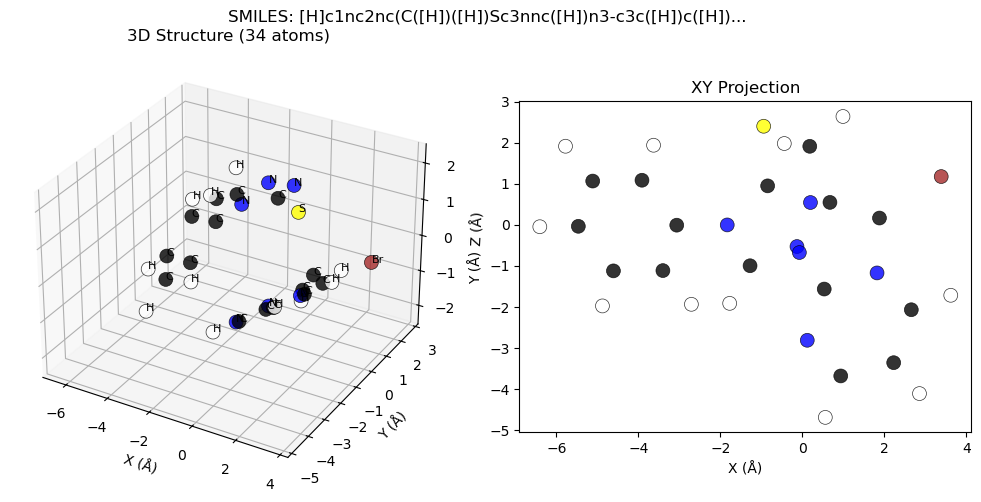

In [22]:
# Visualize a single molecule in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get a molecule with moderate size for better visualization
target_size = 30  # atoms
selected_mol = None
for _, mol in obj[:100]:
    if mol and 20 <= mol.GetNumAtoms() <= 40:
        selected_mol = mol
        break

if selected_mol:
    z_np, pos_np = mol_to_arrays(selected_mol)
    
    # Create color map for different atom types
    atom_colors = {
        1: 'white',    # H
        6: 'black',    # C
        7: 'blue',     # N
        8: 'red',      # O
        9: 'green',    # F
        15: 'orange',  # P
        16: 'yellow',  # S
        17: 'lime',    # Cl
        35: 'brown',   # Br
    }
    
    colors = [atom_colors.get(int(z), 'gray') for z in z_np]
    
    fig = plt.figure(figsize=(10, 5))
    
    # 3D visualization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pos_np[:, 0], pos_np[:, 1], pos_np[:, 2], 
                c=colors, s=100, alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Add atom labels
    for i, (x, y, z) in enumerate(pos_np):
        symbol = Chem.GetPeriodicTable().GetElementSymbol(int(z_np[i]))
        ax1.text(x, y, z, symbol, fontsize=8)
    
    ax1.set_xlabel('X (Å)')
    ax1.set_ylabel('Y (Å)')
    ax1.set_zlabel('Z (Å)')
    ax1.set_title(f'3D Structure ({selected_mol.GetNumAtoms()} atoms)')
    
    # 2D projection
    ax2 = fig.add_subplot(122)
    ax2.scatter(pos_np[:, 0], pos_np[:, 1], 
                c=colors, s=100, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax2.set_xlabel('X (Å)')
    ax2.set_ylabel('Y (Å)')
    ax2.set_title('XY Projection')
    ax2.set_aspect('equal')
    
    plt.suptitle(f"SMILES: {Chem.MolToSmiles(selected_mol)[:50]}...")
    plt.tight_layout()
    plt.show()
else:
    print("No suitable molecule found for visualization")

In [23]:
pos_np

array([[ 3.38385725e+00,  1.17896903e+00, -1.24772497e-01],
       [ 1.87822843e+00,  1.67840317e-01, -5.56116581e-01],
       [ 6.70606256e-01,  5.49516141e-01, -1.11345792e+00],
       [-1.33208185e-01, -5.26642203e-01, -1.25885427e+00],
       [ 5.31447828e-01, -1.56343138e+00, -8.01760793e-01],
       [ 1.17768399e-01, -2.81268024e+00, -6.99497581e-01],
       [ 9.33954597e-01, -3.68201804e+00, -1.65591314e-01],
       [ 2.22473216e+00, -3.35882902e+00,  3.01015377e-01],
       [ 2.65461040e+00, -2.06801248e+00,  1.98664963e-01],
       [ 1.81933737e+00, -1.17038250e+00, -3.56650293e-01],
       [ 3.61650109e+00, -1.71533287e+00,  5.43337166e-01],
       [ 2.85374808e+00, -4.11235428e+00,  7.42198408e-01],
       [ 5.57716608e-01, -4.69210911e+00, -8.85718167e-02],
       [ 1.78758383e-01,  1.91679955e+00, -1.32871079e+00],
       [-4.42153960e-01,  1.98462653e+00, -2.21931314e+00],
       [ 9.88151610e-01,  2.64389133e+00, -1.35240018e+00],
       [-9.45235193e-01,  2.40595508e+00

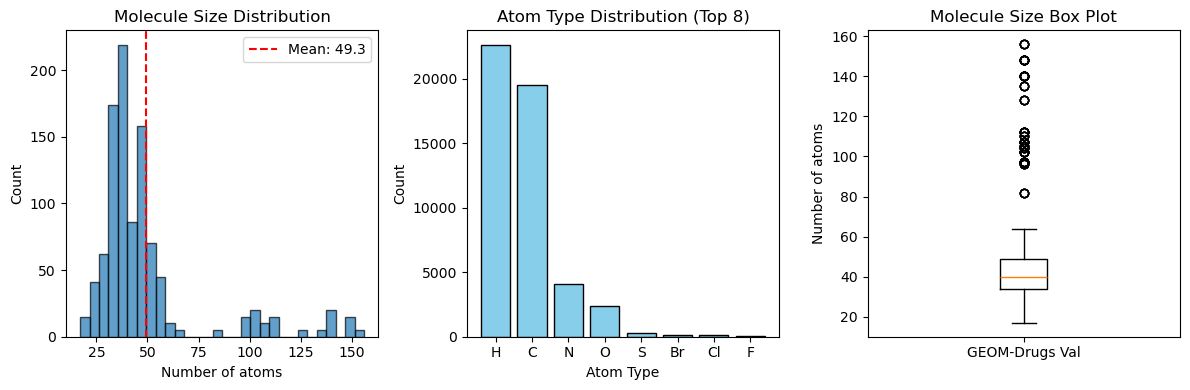


Dataset Summary:
- Format: List of (protein, RDKit.Mol) tuples
- Protein part: Always None (unconditional generation)
- Each molecule has 3D coordinates (conformer)
- Common atoms: H (22,629), C (19,559), N (4,062), O (2,354), S (322)


In [8]:
# Visualize atom size distribution
plt.figure(figsize=(12, 4))

# Histogram of molecule sizes
plt.subplot(1, 3, 1)
plt.hist(num_atoms_array, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Number of atoms')
plt.ylabel('Count')
plt.title('Molecule Size Distribution')
plt.axvline(num_atoms_array.mean(), color='red', linestyle='--', label=f'Mean: {num_atoms_array.mean():.1f}')
plt.legend()

# Atom type distribution
plt.subplot(1, 3, 2)
atoms, counts = zip(*sorted_atoms[:8])
plt.bar(atoms, counts, color='skyblue', edgecolor='black')
plt.xlabel('Atom Type')
plt.ylabel('Count')
plt.title('Atom Type Distribution (Top 8)')
plt.xticks(rotation=0)

# Box plot of molecule sizes
plt.subplot(1, 3, 3)
plt.boxplot(num_atoms_array, vert=True)
plt.ylabel('Number of atoms')
plt.title('Molecule Size Box Plot')
plt.xticks([1], ['GEOM-Drugs Val'])

plt.tight_layout()
plt.show()

print(f"\nDataset Summary:")
print(f"- Format: List of (protein, RDKit.Mol) tuples")
print(f"- Protein part: Always None (unconditional generation)")
print(f"- Each molecule has 3D coordinates (conformer)")
print(f"- Common atoms: {', '.join([f'{a} ({c:,})' for a, c in sorted_atoms[:5]])}")

In [9]:
# Based on LMDB code, the .pt file contains list of (protein, molecule) tuples
# For unconditional generation, protein is likely None or ignored
# The molecule is an RDKit Mol object

# Let's properly explore the structure
print(f"Total molecules in dataset: {len(obj)}")
print(f"First item type: {type(obj[0])}")

# Check the first few items
for i in range(min(3, len(obj))):
    item = obj[i]
    if isinstance(item, tuple):
        protein, mol = item
        print(f"\nItem {i}:")
        print(f"  Protein: {type(protein)} - {protein if protein is not None else 'None'}")
        print(f"  Molecule: {type(mol)}")
        
# Get the RDKit molecule
_, first_mol = obj[0]
print(f"\nFirst molecule type: {type(first_mol)}")

# Check if it's an RDKit molecule
try:
    from rdkit import Chem
    if isinstance(first_mol, Chem.Mol):
        print("✓ Confirmed: This is an RDKit Mol object")
        print(f"Number of atoms: {first_mol.GetNumAtoms()}")
        print(f"Number of bonds: {first_mol.GetNumBonds()}")
        print(f"SMILES: {Chem.MolToSmiles(first_mol)}")
except ImportError:
    print("RDKit not imported yet")

Total molecules in dataset: 146411
First item type: <class 'tuple'>

Item 0:
  Protein: <class 'NoneType'> - None
  Molecule: <class 'rdkit.Chem.rdchem.Mol'>

Item 1:
  Protein: <class 'NoneType'> - None
  Molecule: <class 'rdkit.Chem.rdchem.Mol'>

Item 2:
  Protein: <class 'NoneType'> - None
  Molecule: <class 'rdkit.Chem.rdchem.Mol'>

First molecule type: <class 'rdkit.Chem.rdchem.Mol'>
✓ Confirmed: This is an RDKit Mol object
Number of atoms: 34
Number of bonds: 37
SMILES: [H]c1nc2nc(C([H])([H])Sc3nnc([H])n3-c3c([H])c([H])c([H])c([H])c3[H])c(Br)n2c([H])c1[H]
